# NLP in Pyspark's MLlib Project

## The Problem
Use the attached dataset to create an NLP alogorthim which automatically flags suspicious posts for review.

#### The Data
This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs.

**Data Source:** https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

In [ ]:
# Google Colab
!pip install pyspark

# Databricks
# import findspark
# findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NLP").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Total cores working are ", cores)
print(spark)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=29e6a9a3a68cc1d3a3c8e48fec7315fd34a11790d22b394e961d7f8f75e097f8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
Total cores working are  1


In [ ]:
from pyspark.ml.feature import (
    RegexTokenizer,
    StopWordsRemover,
    HashingTF,
    IDF,
    StringIndexer,
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import (
    col,
    countDistinct,
    regexp_replace,
    lower,
)

In [ ]:
postings = spark.read.csv("fake_job_postings.csv", inferSchema=True, header=True)

In [ ]:
postings.limit(8).toPandas()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,None,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",None,None,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,None,0,1,0,None,None,None,None,None,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,None,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",None,None,None,Job OverviewApex is an environmental consultin...,None,None,0,0,0,None,None,None,None,None,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",None,None,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,None,None,None,None,None,0


In [ ]:
postings.filter("fraudulent=1").show(1, False)

+------+-----------------+---------------+----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
postings.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- location: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary_range: string (nullable = true)
 |-- company_profile: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- telecommuting: string (nullable = true)
 |-- has_company_logo: string (nullable = true)
 |-- has_questions: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- required_experience: string (nullable = true)
 |-- required_education: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- function: string (nullable = true)
 |-- fraudulent: string (nullable = true)



In [ ]:
postings.count()

17880

In [ ]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if nullRows > 0:
            temp = k, nullRows, (nullRows / numRows) * 100
            null_columns_counts.append(temp)
    return null_columns_counts


null_columns_calc_list = null_value_calc(postings)
spark.createDataFrame(
    null_columns_calc_list, ["Column_Name", "Null_Values_Count", "Null_Value_Percent"]
).show()

+-------------------+-----------------+--------------------+
|        Column_Name|Null_Values_Count|  Null_Value_Percent|
+-------------------+-----------------+--------------------+
|           location|              346|  1.9351230425055927|
|         department|            11547|   64.58053691275167|
|       salary_range|            15011|   83.95413870246085|
|    company_profile|             3308|  18.501118568232663|
|        description|                1|0.005592841163310962|
|       requirements|             2573|  14.390380313199106|
|           benefits|             6966|   38.95973154362416|
|      telecommuting|               89| 0.49776286353467564|
|   has_company_logo|               29|  0.1621923937360179|
|      has_questions|               30| 0.16778523489932887|
|    employment_type|             3292|   18.41163310961969|
|required_experience|             6723|  37.600671140939596|
| required_education|             7748|  43.333333333333336|
|           industry|   

In [ ]:
df = postings.na.drop(subset=["fraudulent", "description"])

In [ ]:
df.count()

17704

In [ ]:
df.groupBy("fraudulent").count().orderBy(col("count").desc()).show(6)

+--------------------+-----+
|          fraudulent|count|
+--------------------+-----+
|                   0|16080|
|                   1|  886|
|           Full-time|   73|
|Hospital & Health...|   55|
|   Bachelor's Degree|   53|
|         Engineering|   26|
+--------------------+-----+
only showing top 6 rows



In [ ]:
#delete invalid data
df = df.filter("fraudulent IN('0','1')")
df.groupBy("fraudulent").count().show(truncate=False)

+----------+-----+
|fraudulent|count|
+----------+-----+
|0         |16080|
|1         |886  |
+----------+-----+



In [ ]:
# remove class imbalance using spark sample by
df = df.sampleBy("fraudulent", fractions={"0": 0.4, "1": 1.0}, seed=10)
df.groupBy("fraudulent").count().show(truncate=False)

+----------+-----+
|fraudulent|count|
+----------+-----+
|0         |6485 |
|1         |886  |
+----------+-----+



In [ ]:
# encoding the label column
indexer = StringIndexer(inputCol="fraudulent", outputCol="label")
df = indexer.fit(df).transform(df)
df.limit(6).toPandas()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,label
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0,0.0
1,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0.0
2,6,Accounting Clerk,"US, MD,",None,None,None,Job OverviewApex is an environmental consultin...,None,None,0,0,0,None,None,None,None,None,0,0.0
3,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",None,None,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,None,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,0.0
4,12,Talent Sourcer (6 months fixed-term contract),"GB, LND, London",HR,None,Want to build a 21st century financial service...,TransferWise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,1,0,None,None,None,None,None,0,0.0
5,13,"Applications Developer, Digital","US, CT, Stamford",None,None,"Novitex Enterprise Solutions, formerly Pitney ...","The Applications Developer, Digital will devel...",Requirements:4 – 5 years’ experience in develo...,None,0,1,0,Full-time,Associate,Bachelor's Degree,Management Consulting,Information Technology,0,0.0


In [ ]:
# lexical analysis

# Removing anything that is not a letter
df = df.withColumn("description", regexp_replace(df["description"], "[^A-Za-z ]+", ""))
# Remove multiple spaces
df = df.withColumn("description", regexp_replace(df["description"], " +", " "))
# Lower case everything
df = df.withColumn("description", lower(df["description"]))

In [ ]:
df.limit(8).toPandas()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,label
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...",food a fastgrowing james beard awardwinning on...,Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0,0.0
1,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,job title itemization review managerlocation f...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0.0
2,6,Accounting Clerk,"US, MD,",None,None,None,job overviewapex is an environmental consultin...,None,None,0,0,0,None,None,None,None,None,0,0.0
3,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",None,None,"Novitex Enterprise Solutions, formerly Pitney ...",the customer service associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,None,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,0.0
4,12,Talent Sourcer (6 months fixed-term contract),"GB, LND, London",HR,None,Want to build a 21st century financial service...,transferwise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,1,0,None,None,None,None,None,0,0.0
5,13,"Applications Developer, Digital","US, CT, Stamford",None,None,"Novitex Enterprise Solutions, formerly Pitney ...",the applications developer digital will develo...,Requirements:4 – 5 years’ experience in develo...,None,0,1,0,Full-time,Associate,Bachelor's Degree,Management Consulting,Information Technology,0,0.0
6,22,Front End Developer,"NZ, N, Auckland",None,None,Frustrated with the status quo?Like to re-imag...,want to be part of a globally focused tech tea...,You will most likely have:A solid mastery of m...,You will be part of an awesome team of innovat...,0,1,0,Full-time,Mid-Senior level,Master's Degree,Consumer Electronics,Engineering,0,0.0
7,25,Customer Service,"GB, LND, London",None,None,None,we are a canary wharf based ecommerce company ...,None,None,0,0,0,None,None,None,None,None,0,0.0


In [ ]:
regex_tokenizer = RegexTokenizer(
    inputCol="description", outputCol="words_array", pattern="\\W"
)
df = regex_tokenizer.transform(df)

df.limit(6).toPandas()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,label,words_array
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...",food a fastgrowing james beard awardwinning on...,Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0,0.0,"[food, a, fastgrowing, james, beard, awardwinn..."
1,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,job title itemization review managerlocation f...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0.0,"[job, title, itemization, review, managerlocat..."
2,6,Accounting Clerk,"US, MD,",None,None,None,job overviewapex is an environmental consultin...,None,None,0,0,0,None,None,None,None,None,0,0.0,"[job, overviewapex, is, an, environmental, con..."
3,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",None,None,"Novitex Enterprise Solutions, formerly Pitney ...",the customer service associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,None,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,0.0,"[the, customer, service, associate, will, be, ..."
4,12,Talent Sourcer (6 months fixed-term contract),"GB, LND, London",HR,None,Want to build a 21st century financial service...,transferwise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,1,0,None,None,None,None,None,0,0.0,"[transferwise, is, the, clever, new, way, to, ..."
5,13,"Applications Developer, Digital","US, CT, Stamford",None,None,"Novitex Enterprise Solutions, formerly Pitney ...",the applications developer digital will develo...,Requirements:4 – 5 years’ experience in develo...,None,0,1,0,Full-time,Associate,Bachelor's Degree,Management Consulting,Information Technology,0,0.0,"[the, applications, developer, digital, will, ..."


In [ ]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words_array", outputCol="filtered_words_array")
feature_data = remover.transform(df)

feature_data.limit(5).toPandas()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,label,words_array,filtered_words_array
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...",food a fastgrowing james beard awardwinning on...,Experience with content management systems a m...,None,0,...,0,Other,Internship,None,None,Marketing,0,0.0,"[food, a, fastgrowing, james, beard, awardwinn...","[food, fastgrowing, james, beard, awardwinning..."
1,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,job title itemization review managerlocation f...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0.0,"[job, title, itemization, review, managerlocat...","[job, title, itemization, review, managerlocat..."
2,6,Accounting Clerk,"US, MD,",None,None,None,job overviewapex is an environmental consultin...,None,None,0,...,0,None,None,None,None,None,0,0.0,"[job, overviewapex, is, an, environmental, con...","[job, overviewapex, environmental, consulting,..."
3,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",None,None,"Novitex Enterprise Solutions, formerly Pitney ...",the customer service associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,None,0,...,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,0.0,"[the, customer, service, associate, will, be, ...","[customer, service, associate, based, phoenix,..."
4,12,Talent Sourcer (6 months fixed-term contract),"GB, LND, London",HR,None,Want to build a 21st century financial service...,transferwise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,...,0,None,None,None,None,None,0,0.0,"[transferwise, is, the, clever, new, way, to, ...","[transferwise, clever, new, way, move, money, ..."


In [ ]:
hashingTF = HashingTF(inputCol="filtered_words_array", outputCol="rawfeatures", numFeatures=20)
HTFfeaturizedData = hashingTF.transform(feature_data)

idf = IDF(inputCol="rawfeatures", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)
TFIDFfeaturizedData.name = "TFIDFfeaturizedData"

HTFfeaturizedData = HTFfeaturizedData.withColumnRenamed("rawfeatures", "features")
HTFfeaturizedData.name = "HTFfeaturizedData"

# Train and Evaluate the model


In [ ]:
def ClassTrainEval(classifier, features, classes, train, test):
    result = None

    def FindMtype(classifier):
        return type(classifier).__name__

    Mtype = FindMtype(classifier)

    def IntanceFitModel(Mtype, classifier, train):
        if Mtype == "LogisticRegression":
            paramGrid = (
                ParamGridBuilder()
                .addGrid(classifier.maxIter, [10, 15, 20])
                .build()
            )
            crossval = CrossValidator(
                estimator=classifier,
                estimatorParamMaps=paramGrid,
                evaluator=MulticlassClassificationEvaluator(),
                numFolds=2,
            )
            fitModel = crossval.fit(train)
            return fitModel

    fitModel = IntanceFitModel(Mtype, classifier, train)

    if fitModel is not None:
        if Mtype == "LogisticRegression":
            BestModel = fitModel.bestModel
            print(" ")
            print(Mtype, " Coefficient Matrix")
            print("You should compare these relative to each other")
            print("Coefficients: \n" + str(BestModel.coefficientMatrix))
            print("Intercept: " + str(BestModel.interceptVector))

    return fitModel

In [ ]:
classifier = LogisticRegression()
featureDF = HTFfeaturizedData

train, test = featureDF.randomSplit([0.7, 0.3], seed=11)
features = featureDF.select(["features"]).collect()

class_count = featureDF.select(countDistinct("label")).collect()
classes = class_count[0][0]

fitModel = ClassTrainEval(classifier, features, classes, train, test)

 
LogisticRegression  Coefficient Matrix
You should compare these relative to each other
Coefficients: 
DenseMatrix([[-0.02075927, -0.0099179 ,  0.00642929,  0.0405692 , -0.01104636,
              -0.00152493,  0.08088699, -0.01647532, -0.03328792, -0.01198675,
               0.04212437, -0.09876073, -0.07818354, -0.02625849, -0.03267903,
               0.0799419 ,  0.02067402, -0.0047721 ,  0.05212604, -0.00293851]])
Intercept: [-1.777340905204671]


In [ ]:
if fitModel is not None:
    predictions = fitModel.transform(test)

    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Accuracy:", accuracy)

    evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")
    recall = evaluator.evaluate(predictions)
    print("Recall:", recall)

    evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
    precision = evaluator.evaluate(predictions)
    print("Precision:", precision)

    evaluator = MulticlassClassificationEvaluator(metricName="f1")
    f1_score = evaluator.evaluate(predictions)
    print("F1 Score:", f1_score)

    evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
    auc_roc = evaluator.evaluate(predictions)
    print("AUC-ROC:", auc_roc)

    evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")
    auc_pr = evaluator.evaluate(predictions)
    print("AUC-PR:", auc_pr)

Accuracy: 0.8858067498844198
Recall: 0.8858067498844198
Precision: 0.7877484760435784
F1 Score: 0.8339048589252689
AUC-ROC: 0.5818887174211222
AUC-PR: 0.14974245492570046


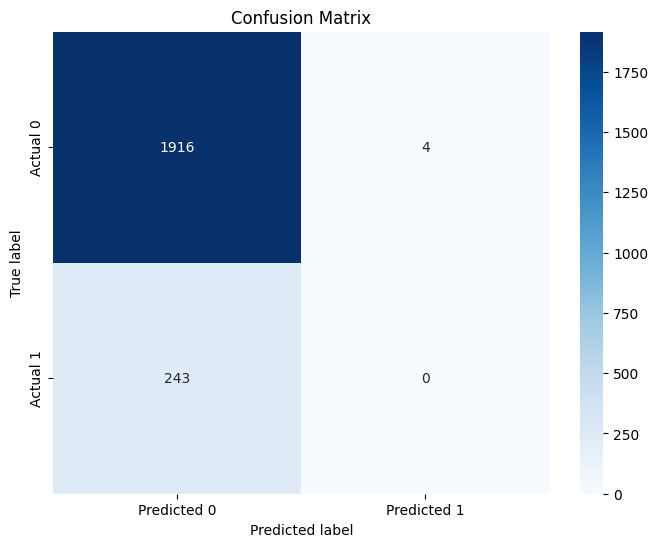

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

predictions_pd = predictions.select("prediction").toPandas()
labels_pd = predictions.select("label").toPandas()

conf_matrix = confusion_matrix(labels_pd, predictions_pd)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
